In [2]:
import pandas as pd 
import numpy as np
from sklearn.cluster import KMeans
from Bio import SeqIO, AlignIO
from Bio.Seq import Seq

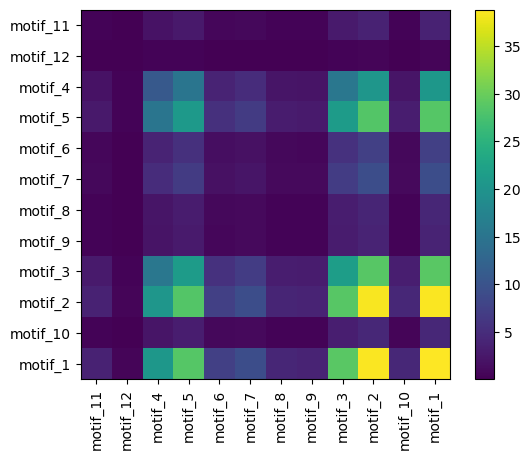

In [14]:
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET

# Read MEME output
meme_xml = ET.parse('utp-data/meme_out/meme.xml')

# Get all scanned sites
sites = meme_xml.findall('.//scanned_sites')

# Get scanned_site for each tag
scanned_sites = [(tag.attrib["sequence_id"], site.attrib["motif_id"]) for tag in sites for site in tag.findall('scanned_site')]

# Get unique motifs
unique_motifs = set([motif for _, motif in scanned_sites])

# Create an empty matrix
matrix = np.zeros((len(unique_motifs), len(unique_motifs)))

# Count motif co-occurrences
for seq, motif in scanned_sites:
    i = list(unique_motifs).index(motif)
    for _, other_motif in scanned_sites:
        j = list(unique_motifs).index(other_motif)
        matrix[i, j] += 1

# Calculate the fraction of sequences where motif i and j occur together
total_sequences = len(scanned_sites)
matrix /= total_sequences

import matplotlib.pyplot as plt

# Get motif labels
motif_labels = list(unique_motifs)

# Plot the matrix with motif labels
plt.imshow(matrix)
plt.colorbar()

# Set x and y axis labels
plt.xticks(range(len(motif_labels)), motif_labels, rotation='vertical')
plt.yticks(range(len(motif_labels)), motif_labels)

plt.show()


In [18]:
aligns = AlignIO.read("utp-data/c-term-with-cialign.fasta", "fasta")
align_len = len(aligns[0].seq)

# remove gaps
for align in aligns:
    id = " ".join(align.description.split(" ")[1:])
    align.id = id
    align.description = ""
    seq_no_gaps = Seq("".join([char for char in align.seq if char != "-"]))
    align.seq = seq_no_gaps

good_aligns = [align for align in aligns if len(align.seq)/align_len > 0.6]

lengths = np.array([len(align.seq) for align in good_aligns])
lengths.mean(), lengths.std()

(93.20388349514563, 6.001390167918736)

In [19]:
SeqIO.write(good_aligns, "utp-data/c-term-with-cialign-no-gaps.fasta", "fasta")

206

In [23]:
# create set of proteins without the c-terminal

c_term_ids = [align.id for align in good_aligns]

db = SeqIO.parse("data/ADK1075_proteomics_DB_2.fasta", "fasta")

db_no_c_term = [seq for seq in db if seq.id not in c_term_ids]

In [24]:
# write to file
SeqIO.write(db_no_c_term, "utp-data/proteomics_DB_no_c_term.fasta", "fasta")

44157

In [27]:
# read tsv, ignore comments
df = pd.read_csv("utp-data/tomtom.tsv", sep="\t", comment="#")
df

,Query_ID,Target_ID,Optimal_offset,p-value,E-value,q-value,Overlap,Query_consensus,Target_consensus,Orientation
0,TQTQLGACMGALGLHLGSRLD,ELME000293,-9,0.002552,0.495143,0.474833,5,TQTQLGACMGALGLHLGSRLD,DALGL,+
1,TQTQLGACMGALGLHLGSRLD,ELME000346,-3,0.004921,0.954761,0.474833,11,TQTQLGACMGALGLHLGSRLD,FLLALLLALLL,+
2,TQTQLGACMGALGLHLGSRLD,ELME000329,-11,0.009590,1.860430,0.616835,10,TQTQLGACMGALGLHLGSRLD,LLLLLLLLLLLF,+
3,TQTQLGACMGALGLHLGSRLD,ELME000235,-6,0.016369,3.175570,0.789657,8,TQTQLGACMGALGLHLGSRLD,LLLGLLPL,+
4,TQTQLGACMGALGLHLGSRLD,ELME000094,-18,0.041728,8.095250,0.994664,3,TQTQLGACMGALGLHLGSRLD,RGD,+
...,...,...,...,...,...,...,...,...,...,...
134,CGAFLGGVLAS,ELME000329,0,0.010087,1.956900,0.978299,11,CGAFLGGALAS,LLLLLLLLLLLF,+
135,CGAFLGGVLAS,ELME000129,2,0.026434,5.128200,0.999845,7,CGAFLGGALAS,GLPGERLLG,+
136,CGAFLGGVLAS,ELME000235,-2,0.035702,6.926220,0.999845,8,CGAFLGGALAS,LLLGLLPL,+
137,CGAFLGGVLAS,ELME000477,-3,0.036071,6.997710,0.999845,4,CGAFLGGALAS,FLLP,+


In [33]:
df["Query_ID"].value_counts(), len(df["Query_ID"].unique())

(Query_ID
 LPDFPEPF                 18
 PPAAPGDAACEWLGE          17
 WRAALLGRAP               15
 BLPEFPPG                 15
 PPIPRLLP                 13
 ALGRPPAA                 13
 LQLPDFPDF                11
 PPPATSAECESVLEK           9
 TQTQLGACMGALGLHLGSRLD     8
 WLEEWRERLECWW             7
 EPGCEWVE                  7
 CGAFLGGVLAS               6
 Name: count, dtype: int64,
 12)

In [40]:
# Select Query_ID s with E-value < 0.05
signif_df = df[df["p-value"] < 0.05]

# Select best match for each query
best_matches = signif_df.groupby("Query_ID").apply(lambda x: x.loc[x["E-value"].idxmin()], include_groups=False)
best_matches["Overlap percent"] = best_matches["Overlap"] / best_matches["Query_consensus"].apply(len)
best_matches

,Target_ID,Optimal_offset,p-value,E-value,q-value,Overlap,Query_consensus,Target_consensus,Orientation,Overlap percent
Query_ID,,,,,,,,,,
ALGRPPAA,ELME000347,1,0.003756,0.728612,0.496195,8,ALGRPPAA,LLLGWPPLLLLRL,+,1.000000
BLPEFPPG,ELME000565,-1,0.001382,0.268075,0.180774,7,DLPAFPPG,LPALPPKL,+,0.875000
CGAFLGGVLAS,ELME000359,1,0.001290,0.250346,0.250307,7,CGAFLGGALAS,SCGHLLAL,+,0.636364
EPGCEWVE,ELME000330,2,0.010861,2.107120,0.851932,5,EPGCEWVE,SLELGRL,+,0.625000
LPDFPEPF,ELME000124,-3,0.000250,0.048576,0.046104,5,LPDFPEPF,FLDLF,+,0.625000
LQLPDFPDF,ELME000452,-2,0.000179,0.034742,0.034267,5,LQLPDFPDF,LLDFP,+,0.555556
PPAAPGDAACEWLGE,ELME000058,0,0.000559,0.108437,0.102422,5,PPAAPGDAACEWLGE,PPLLF,+,0.333333
PPIPRLLP,ELME000004,0,0.000210,0.040755,0.039305,4,PPIPRLLP,PPLP,+,0.500000
PPPATSAECESVLEK,ELME000064,-1,0.002677,0.519250,0.409560,7,PPPATGAECESVLEQ,LLLSLLE,+,0.466667
